In [1]:
"""
notebook designed to compare thickness measurement at picked crossover locations

### psuedocode ###
1. read in pick point dataframe
2. convert points in each track to continuous linestring
3. find all intersection points for all linestrings
4. find closest point in each track at crossing to intersection point for all intersections
5. compare thickness measurements at closes points and build statistics

BST 08OCT2020
python3
"""
### impots ###
import sys, os, itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString


%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]

In [7]:
### functions ###
R = 6367000     # earth's radius in meters

def haversinedist_point_array(plon, plat, lonarray, latarray):
    """
    calculate the great circle distance between points on the earth (specified in decimal degrees)
    """
    plon, plat, lonarray, latarray = map(np.radians, [plon, plat, lonarray, latarray])

    dlon = lonarray - plon
    dlat = latarray - plat

    a = np.sin(dlat/2.0)**2 + np.cos(plat) * np.cos(latarray) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = R * c
    return m

def track_crossings(lines):
    """ 
    append track names and point to crrossings list for each track intersection
    """
    crossings = []
    for line1,line2 in  itertools.combinations(lines, 2):
        if  line1[1].intersects(line2[1]):
            crossing = line1[1].intersection(line2[1])
            if "Point" == crossing.type:
                crossings.append([line1[0],line2[0],crossing])
            elif "MultiPoint" == crossing.type:
                for pt in crossing:
                    crossings.append([line1[0],line2[0],pt])
            elif "MultiLineString" == crossing.type:
                multiLine = [line for line in crossing]
                first_coords = multiLine[0].coords[0]
                last_coords = multiLine[len(multiLine)-1].coords[1]
                crossings.append([line1[0],Point(first_coords[0], first_coords[1])])
                crossings.append([line2[0],Point(last_coords[0], last_coords[1])])
    return crossings

def interp3d(x1, y1, z1, x2, y2, z2 , x, y):
    """
    interpolate zvalue on 3d line
    """
    b1 = np.sqrt((x2 - x1)**2 + (y2 - y1 )**2)
    b2 = np.sqrt((x - x1)**2 + (y - y1)**2) 
    z =   z1 + b2*(z2 - z1) / b1
    
    return z

In [3]:
### params ###
dpath = "/mnt/c/Users/btobers/Documents/data/radar/malaspina/"
thresh = 100                # distance threshold between crossover points [m]

In [4]:
# now let's try with some malaspin data
df = pd.read_csv(dpath + "malaBed_15_16_18_19_adem2m.csv")
df = df[df["subsrfElev"].notna()]
df.head()

,track,trace,lon,lat,alt,gndElev,srfIdx,srfTwtt,srfAmp,subsrfIdx,subsrfTwtt,subsrfAmp,subsrfElev,thick
103,2015_may14_10,103,-140.438552,59.803015,459.668,156.772156,0.0,0.000004,0.0,0.0,0.000005,0.0,70.566422,86.205734
104,2015_may14_10,104,-140.441008,59.803443,461.771,151.281494,0.0,0.000004,0.0,0.0,0.000005,0.0,61.695143,89.586351
105,2015_may14_10,105,-140.442650,59.803738,462.082,142.160660,0.0,0.000003,0.0,0.0,0.000005,0.0,47.503383,94.657277
106,2015_may14_10,106,-140.445121,59.804195,462.978,150.176193,0.0,0.000003,0.0,0.0,0.000005,0.0,48.757683,101.418511
107,2015_may14_10,107,-140.446767,59.804507,464.501,156.506256,0.0,0.000003,0.0,0.0,0.000005,0.0,48.326511,108.179745


In [5]:
# lets try converting points in each track to it's own linestring then seeing where linestrings intersect

# Zip the coordinates into a point object and convert to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = GeoDataFrame(df, geometry=geometry)

# Aggregate these points with the GroupBy
gdf2 = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf2 = GeoDataFrame(gdf2, geometry="geometry")

# compile list of lines with linestring
lines = list(gdf2["geometry"])
lines = [tuple((fname, lines[_i])) for _i, fname in enumerate(gdf2.index.values)]

In [6]:
# get all line crossings
crossings = track_crossings(lines)

In [9]:
# ensure crossings list looks like what we want
# each sublist should have: [track0Name, track1Name, shapelyPoint]
print(crossings[0])

['2015_may14_10', '2015_may14_18', <shapely.geometry.point.Point object at 0x7f6e5f9f6d90>]


In [13]:
# let's get the two surrounding points on each track to each intersection point
rem_idx = []        # indices of crossings list elements to remove if distance is above threshold
# initialize arrays to hold interpolated values
lon_arr = np.array(())
lat_arr = np.array(())
track0_arr = np.array(())
track1_arr = np.array(())
zsrf0_arr = np.array(())
zsrf1_arr = np.array(())
zbed0_arr = np.array(())
zbed1_arr = np.array(())
thick0_arr = np.array(())
thick1_arr = np.array(())

# loop through crossings
for _i, crossing in enumerate(crossings):
    pt = crossing[2]
    df_sub0 = df[df["track"]==crossing[0]]
    df_sub1 = df[df["track"]==crossing[1]]
    
    # get distance of each point in track to intersection point
    dist0 = haversinedist_point_array(df_sub0["lon"].to_numpy(), df_sub0["lat"].to_numpy(), 
            pt.x, pt.y)
    dist1 = haversinedist_point_array(df_sub1["lon"].to_numpy(), df_sub1["lat"].to_numpy(), 
            pt.x, pt.y)

    # make sure closest point to each intersection is below threshold distance specified
    if dist0.min() < thresh and dist1.min() < thresh:
        # sort distances to get two closes indices
        t0sort = np.argsort(dist0)
        t1sort = np.argsort(dist1)

        # get lon, lat, surface elev, thickness, and bed elev for two surrounding points on each track
        x0 = [df_sub0["lon"].iloc[t0sort[0]], df_sub0["lon"].iloc[t0sort[1]]]
        y0 = [df_sub0["lat"].iloc[t0sort[0]], df_sub0["lat"].iloc[t0sort[1]]]
        zsrf0 = [df_sub0["gndElev"].iloc[t0sort[0]], df_sub0["gndElev"].iloc[t0sort[1]]]
        zbed0 = [df_sub0["subsrfElev"].iloc[t0sort[0]], df_sub0["subsrfElev"].iloc[t0sort[1]]]
        thick0 = [df_sub0["thick"].iloc[t0sort[0]], df_sub0["thick"].iloc[t0sort[1]]]

        x1 = [df_sub1["lon"].iloc[t1sort[0]], df_sub1["lon"].iloc[t1sort[1]]]
        y1 = [df_sub1["lat"].iloc[t1sort[0]], df_sub1["lat"].iloc[t1sort[1]]]
        zsrf1 = [df_sub1["gndElev"].iloc[t1sort[0]], df_sub1["gndElev"].iloc[t1sort[1]]]
        zbed1 = [df_sub1["subsrfElev"].iloc[t1sort[0]], df_sub1["subsrfElev"].iloc[t1sort[1]]]
        thick1 = [df_sub1["thick"].iloc[t1sort[0]], df_sub1["thick"].iloc[t1sort[1]]]

        # get linearly interpolated values for each track at crossing point
        zsrf0_cross = interp3d(x0[0],y0[0],zsrf0[0],x0[1],y0[1],zsrf0[1],pt.x,pt.y)
        zbed0_cross = interp3d(x0[0],y0[0],zbed0[0],x0[1],y0[1],zbed0[1],pt.x,pt.y)
        thick0_cross = interp3d(x0[0],y0[0],thick0[0],x0[1],y0[1],thick0[1],pt.x,pt.y)

        zsrf1_cross = interp3d(x1[0],y1[0],zsrf1[0],x1[1],y1[1],zsrf1[1],pt.x,pt.y)
        zbed1_cross = interp3d(x1[0],y1[0],zbed1[0],x1[1],y1[1],zbed1[1],pt.x,pt.y)
        thick1_cross = interp3d(x1[0],y1[0],thick1[0],x1[1],y1[1],thick1[1],pt.x,pt.y)

        # add values to arrays
        lon_arr = np.append(lon_arr, pt.x)
        lat_arr = np.append(lat_arr, pt.y)
        track0_arr = np.append(track0_arr, crossing[0])
        zsrf0_arr = np.append(zsrf0_arr, zsrf0_cross)
        zbed0_arr = np.append(zbed0_arr, zbed0_cross)
        thick0_arr = np.append(thick0_arr, thick0_cross)

        track1_arr = np.append(track1_arr, crossing[1])
        zsrf1_arr = np.append(zsrf1_arr, zsrf1_cross)
        zbed1_arr = np.append(zbed1_arr, zbed1_cross)
        thick1_arr = np.append(thick1_arr, thick1_cross)        

        # get actual bed elevation at crossing point as average of two measurements
        z = (zbed0_cross + zbed1_cross) / 2

        # get difference between average value at crossing point and measured value for each track and add difference value to crossings list 
        # ***a positive value will indicate a bed elevation measurement below the average, while a negative value will indicate above the average***
        crossings[_i].append(z - zbed0_cross)
        crossings[_i].append(z - zbed1_cross)

    # if closest point further than threshold, remove crossing
    else:
        rem_idx.append(_i)

# remove necessary crossings
for idx in sorted(rem_idx, reverse = True):  
    del crossings[idx] 

In [19]:
# build df
crossings_df = pd.DataFrame({"lon":lon_arr, "lat":lat_arr,
                            "track0":track0_arr, "zsrf0":zsrf0_arr, "zbed0":zbed0_arr, "thick0":thick0_arr,
                            "track1": track1_arr, "zsrf1":zsrf1_arr, "zbed1":zbed1_arr, "thick1":thick1_arr,
                            "dzsrf":np.abs(zsrf0_arr-zsrf1_arr), "dzbed":np.abs(zbed0_arr-zbed1_arr), "dthick":np.abs(thick0_arr-thick1_arr)})

In [21]:
crossings_df
crossings_df.to_csv(dpath + "malapickstats.csv", index=False)

In [13]:
# find closest point on both tracks to each intersection
# initialize arrays to hold data
lon = np.array(())
lat = np.array(())
track0 = np.array(())
track1 = np.array(())
thick0 = np.array(())
thick1 = np.array(())

for _i, crossing in enumerate(crossings):
    df_sub0 = df[df["track"]==crossing[0]]
    df_sub1 = df[df["track"]==crossing[1]]
    
    # get closet point for both tracks to crossing - ensure minimum distances are below threshold
    dist0 = haversinedist_point_array(df_sub0["lon"].to_numpy(), df_sub0["lat"].to_numpy(), crossing[2].x, crossing[2].y)
    dist1 = haversinedist_point_array(df_sub1["lon"].to_numpy(), df_sub1["lat"].to_numpy(), crossing[2].x, crossing[2].y)
    if np.min(dist0) < thresh and np.min(dist1) < thresh:
        point0 = np.argmin(dist0)
        point1 = np.argmin(dist1)

        # get thickness measurement
        lon = np.append(lon, crossing[2].x)
        lat = np.append(lat, crossing[2].y)
        track0 = np.append(track0, crossing[0])
        track1 = np.append(track1, crossing[1])
        thick0 = np.append(thick0, df_sub0["thick"].iloc[point0])
        thick1 = np.append(thick1, df_sub1["thick"].iloc[point1])

In [14]:
# build df
crossings_df = pd.DataFrame({"lon":lon, "lat":lat,
                            "track0":track0, "track1": track1,
                            "thick0":thick0, "thick1":thick1,
                            "diff":np.abs(thick1-thick0)})
crossings_df.to_csv(dpath + "malapickstats.csv", index=False)

In [22]:
crossings_df.describe()

,lon,lat,zsrf0,zbed0,thick0,zsrf1,zbed1,thick1,dzsrf,dzbed,dthick
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,-140.592497,59.939775,361.393948,-71.082587,432.476535,355.400826,-86.577749,441.978575,9.181884,57.182070,55.029228
std,0.199178,0.062086,101.369816,73.852378,124.071890,105.168352,85.244716,135.571117,19.063324,49.668499,48.416205
min,-141.056382,59.774089,104.379518,-252.997194,89.712906,99.235111,-346.768109,75.266716,0.005783,0.013290,0.940078
25%,-140.734724,59.906057,290.106153,-119.932133,353.573862,284.455928,-132.497016,353.906955,0.248572,22.538693,21.381997
50%,-140.582443,59.942283,377.559409,-68.158393,452.744023,362.612626,-86.098011,456.404486,1.142886,41.811358,41.765919
75%,-140.461143,59.980001,439.598978,-25.629073,533.029927,442.311059,-40.254902,533.777565,8.053213,74.405063,71.738460
max,-140.188579,60.104573,535.614576,171.790617,690.570391,550.060558,199.050284,771.973429,88.861485,290.746421,290.871332


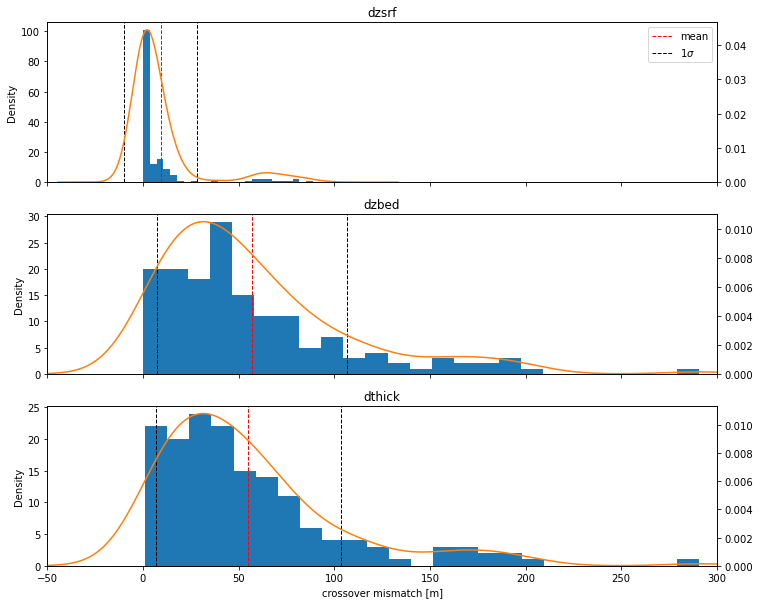

In [66]:
# plot stats
stats_df = crossings_df[["dzsrf","dzbed","dthick"]]

fig, axes = plt.subplots(3, 1,sharex=True,figsize=((12,10)))
for i, (name, col) in enumerate(stats_df.iteritems()):
    ax = axes[i]
    col.hist(ax=ax,bins=25)
    ax.axvline(col.mean(), color='r', linestyle='dashed', linewidth=1,label='mean')
    ax.axvline(col.mean()-col.std(), color='k', linestyle='dashed', linewidth=1,label=r'$1\sigma$')
    ax.axvline(col.mean()+col.std(), color='k', linestyle='dashed', linewidth=1)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)
    ax.set_xlim([-50, 300])

axes[0].legend()
axes[i].set_xlabel("crossover mismatch [m]")
plt.show()
